In [134]:
import importlib
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
# clustering algorithms
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import module

try:
    importlib.reload(module) # reload module
except NameError:
    pass

In [106]:
def catchstate(df, var_name: str) -> 'pd.DataFrame':
    """
    Helper function that captures intermediate Dataframes mid-chain.
    In the global namespace, make a new variable called var_name and set it to dataframe
    """
    globals()[var_name] = df
    return df

# Load Dataset

In [107]:
path = Path("../input/dataset-clean.parquet")
df = pd.read_parquet(path)
df = df.set_index("customer_id")

# Customer Segmentation

## Feature Engineering

In [108]:
df.head()

,invoice_no,invoice_date,description,stock_code,unit_price,quantity,total_price,country
customer_id,,,,,,,,
17850.0,536365,2010-12-01 08:26:00,White Hanging Heart T-Light Holder,85123A,2.55,6,15.30,United Kingdom
17850.0,536365,2010-12-01 08:26:00,White Metal Lantern,71053,3.39,6,20.34,United Kingdom
17850.0,536365,2010-12-01 08:26:00,Cream Cupid Hearts Coat Hanger,84406B,2.75,8,22.00,United Kingdom
17850.0,536365,2010-12-01 08:26:00,Knitted Union Flag Hot Water Bottle,84029G,3.39,6,20.34,United Kingdom
17850.0,536365,2010-12-01 08:26:00,Red Woolly Hottie White Heart.,84029E,3.39,6,20.34,United Kingdom


In [109]:
def prepare_for_segmentation(df):
    """Do feature engineering on dataset for segmentation."""
    return (df
        .groupby("customer_id")
        .agg(
            n_purchase = ("invoice_no", "nunique"), 
            n_item_purchased = ("quantity", "sum"),
            n_unique_item_purchased = ("stock_code", "nunique"),
            total_revenue = ("total_price", "sum"),
            avg_revenue_per_item = ("unit_price", "mean"),
            country = ("country", lambda x: x.unique()[0].lower()),
            recency = ("invoice_date", lambda x: (df["invoice_date"].max() - x.max()).days),
        )    
        .assign(
            country_mapped = lambda df_: df_["country"].rank(method='dense', ascending=False).astype(int),
            avg_revenue_per_purchase = lambda df_: df_["total_revenue"].div(df_["n_purchase"]), 
        )
        .reset_index()
        .pipe(catchstate, var_name="df_intermediate")
        .drop(columns="country")
        .set_index("customer_id")
    )

df_clean = prepare_for_segmentation(df)

In [110]:
country_map = (df_intermediate
    .loc[:, ["country", "country_mapped"]]
    .drop_duplicates()
    .sort_values("country_mapped", ignore_index=True)
)

## Hopkins Test

Now we we will use Hopkins Test to check if the data contains meaningful clusters.

In [111]:
columns= df_clean.columns
scaler= StandardScaler()

X= pd.DataFrame(df_clean
    .pipe(module.drop_outliers, columns, 'z_score')
    .pipe(pd.get_dummies)
    .pipe(scaler.fit_transform)
)
module.hopkins_test(X)

Hopkins statistic=  0.968: there are meaningful clusters


## Select Algorithm and Number of Clustes

In [112]:
clusters= range(2, 7, 1)

models= []
n_clusters= []
silhouette_scores= []

def append_scores(model, i):
    n_clusters.append(i)
    models.append(type(model).__name__)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

for i in tqdm(clusters):
    
    # k-means
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        kmeans= KMeans(n_clusters= i, random_state= 8, init= 'k-means++', n_init= 10)
        cluster_labels= kmeans.fit_predict(X)
        append_scores(kmeans, i)

    # agglomerative clustering
    agglo= AgglomerativeClustering(n_clusters= i)
    cluster_labels= agglo.fit_predict(X)
    append_scores(agglo, i)

results= pd.DataFrame(data= {
    'model': models, 
    'n_clusters': n_clusters, 
    'silhouette_score': silhouette_scores
}).sort_values('silhouette_score', ignore_index= True)
results

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


,model,n_clusters,silhouette_score
0,AgglomerativeClustering,4,0.281006
1,AgglomerativeClustering,5,0.286327
2,AgglomerativeClustering,6,0.292815
3,KMeans,5,0.321465
4,KMeans,4,0.322385
5,KMeans,6,0.324672
6,AgglomerativeClustering,2,0.425108
7,AgglomerativeClustering,3,0.449815
8,KMeans,2,0.472330
9,KMeans,3,0.481820


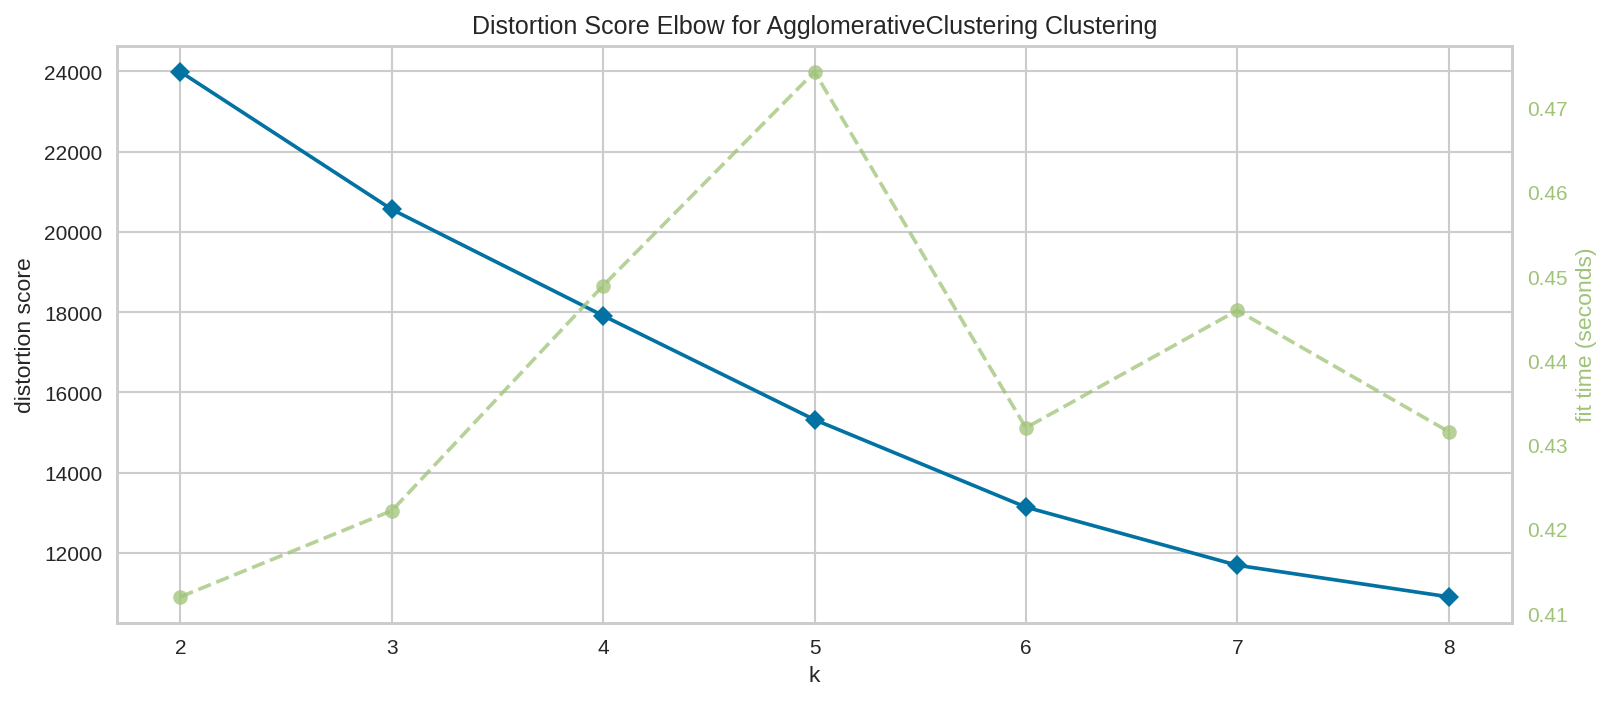

In [117]:
fig, ax= plt.subplots(figsize= (12, 5), dpi= 150)
fig.patch.set_facecolor('white')

kmeans= AgglomerativeClustering(n_clusters= 4)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)

    visualizer = KElbowVisualizer(kmeans, k=(2, 9), metric= 'distortion', ax= ax)
    visualizer.fit(X)      
    visualizer.show()

Based on numerous metrics above, I decided to select 6 clusters with Agglomerative Clustering.

## Segmentation

In [122]:
agglo= AgglomerativeClustering(n_clusters= 4)
scaler= StandardScaler()

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    df_clean= (df_clean
        .pipe(module.drop_outliers, columns, 'z_score')
        .assign(
            segment= lambda df_: agglo.fit_predict(
                df_.pipe(pd.get_dummies).pipe(scaler.fit_transform)
            )
        )
        # make segment categorical so that it is automatically sorted
        .assign(segment= lambda df_: df_['segment']
            .astype(pd.CategoricalDtype([0, 1, 2, 3], ordered= True))
        )
    )

## Segment Profiling

In [144]:
df_clean = df_clean.merge(
    country_map, left_on="country_mapped", right_on="country_mapped", how="left"
)

In [123]:
df_clean.head()

,n_purchase,n_item_purchased,n_unique_item_purchased,total_revenue,avg_revenue_per_item,recency,country_mapped,avg_revenue_per_purchase,segment
customer_id,,,,,,,,,
12363.0,2,408,23,552.00,2.311739,109,2,276.000,0
12739.0,2,486,38,1013.04,4.008421,77,4,506.520,1
12743.0,2,319,114,546.43,3.038582,133,2,273.215,0
12820.0,4,722,55,942.34,1.904746,2,3,235.585,1
12821.0,1,70,6,92.72,2.498333,213,3,92.720,3


In [126]:
df_clean["segment"].value_counts()

segment
1    1105
3     942
0     905
2     296
Name: count, dtype: int64

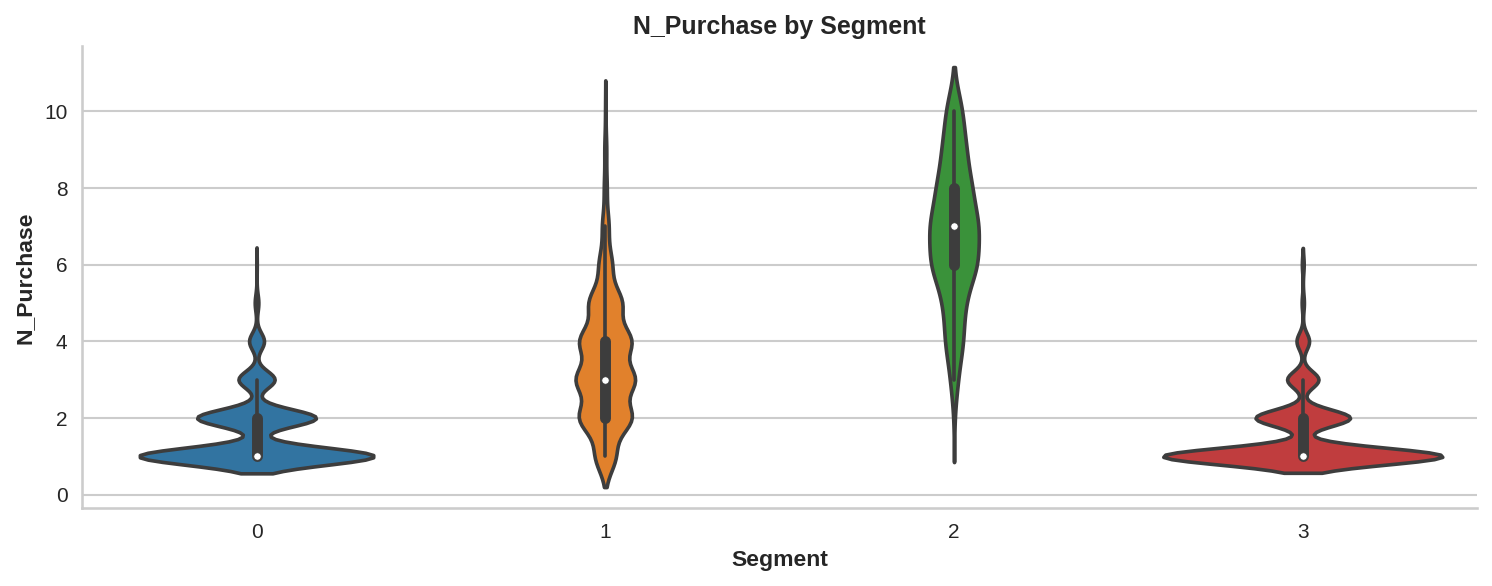

In [127]:
module.plot_violin(
    x= 'segment',
    y= 'n_purchase',
    df= df_clean
)

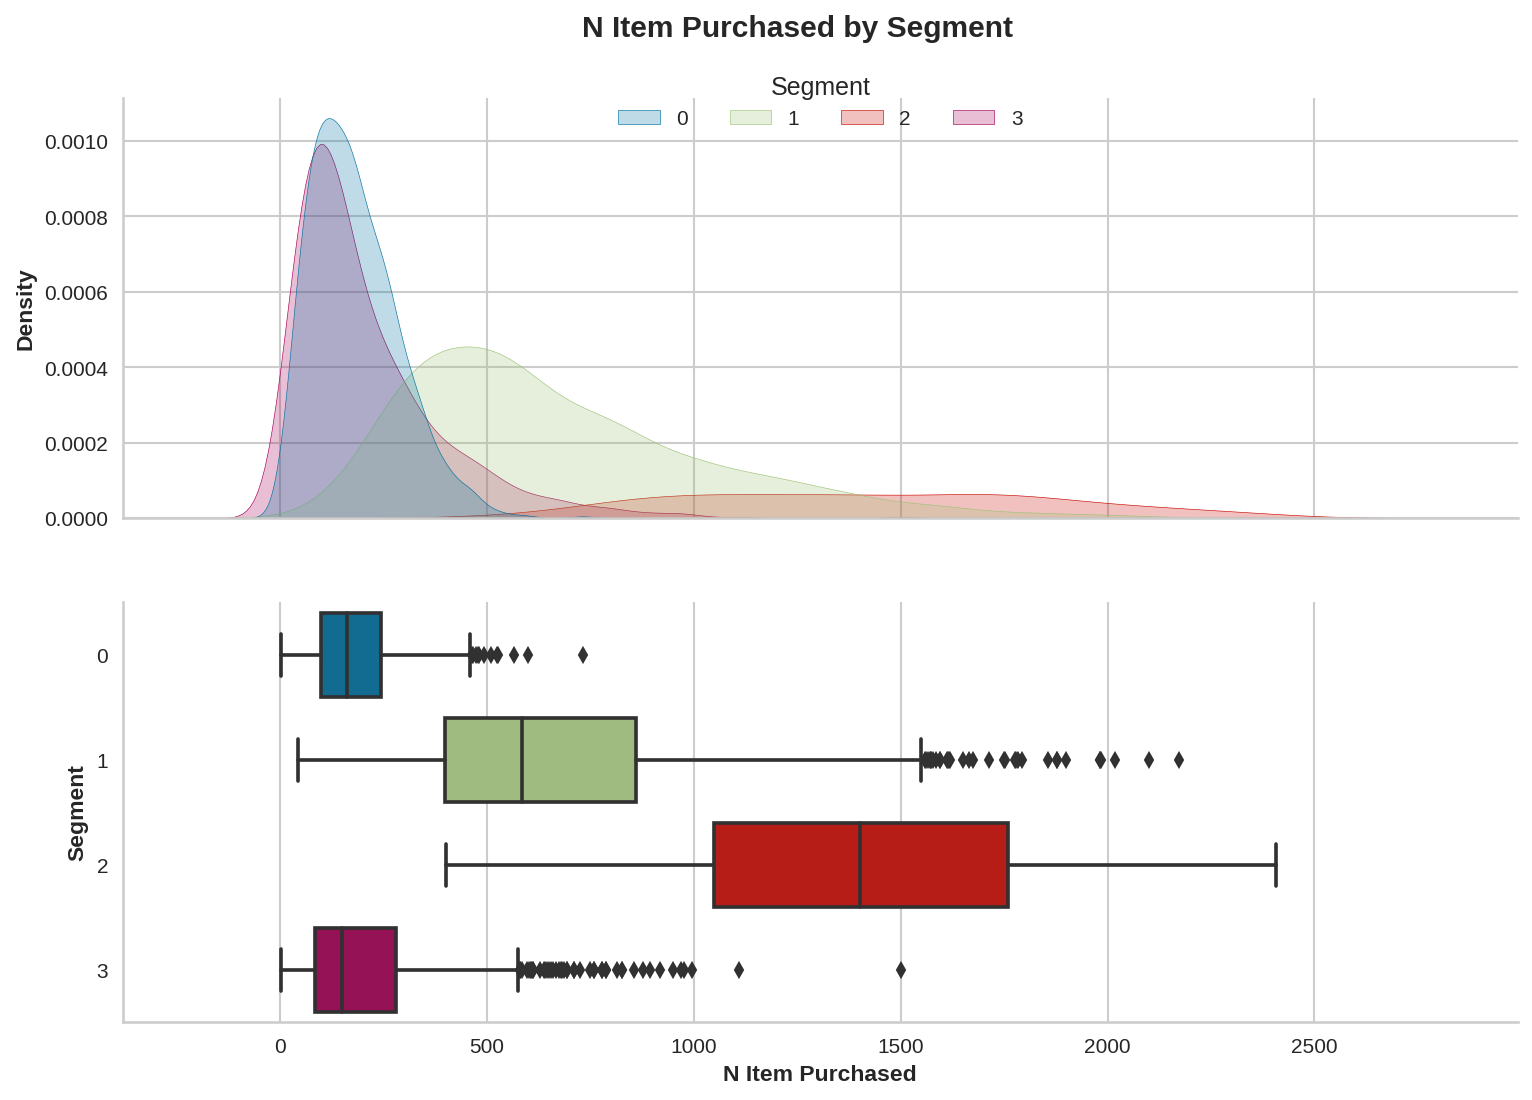

In [128]:
module.plot_kde_box(y= 'segment', x= 'n_item_purchased', df= df_clean)

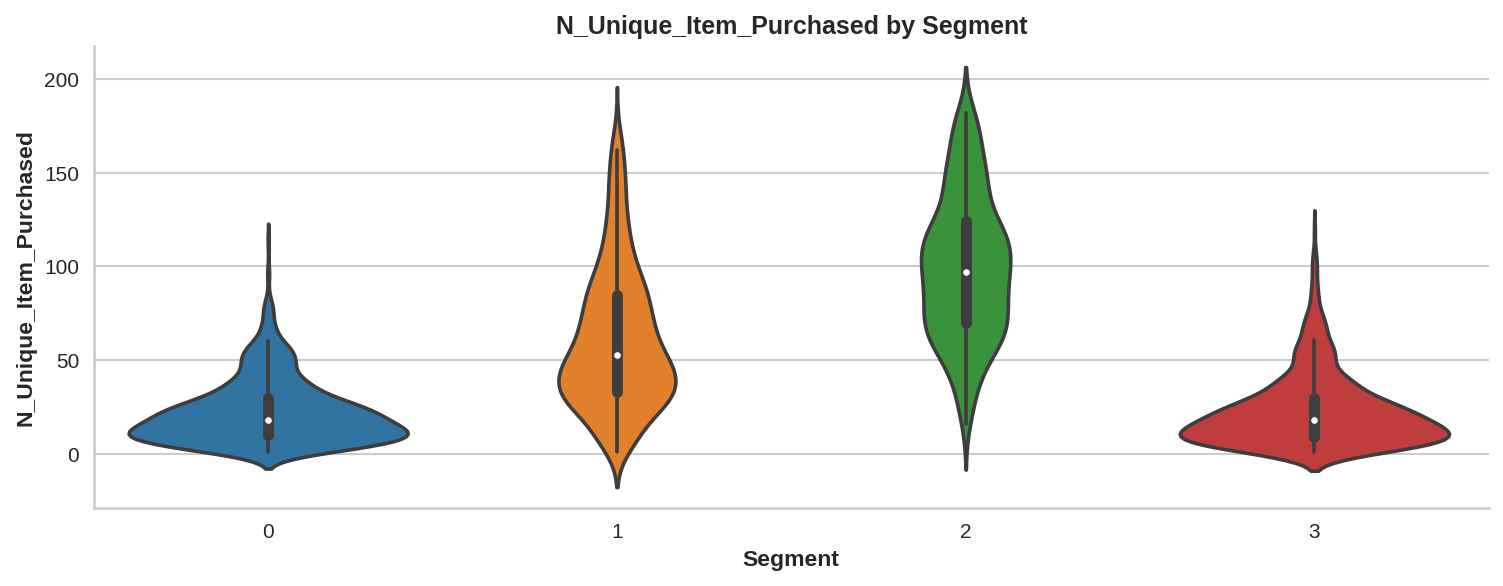

In [129]:
module.plot_violin(
    x= 'segment',
    y= 'n_unique_item_purchased',
    df= df_clean
)

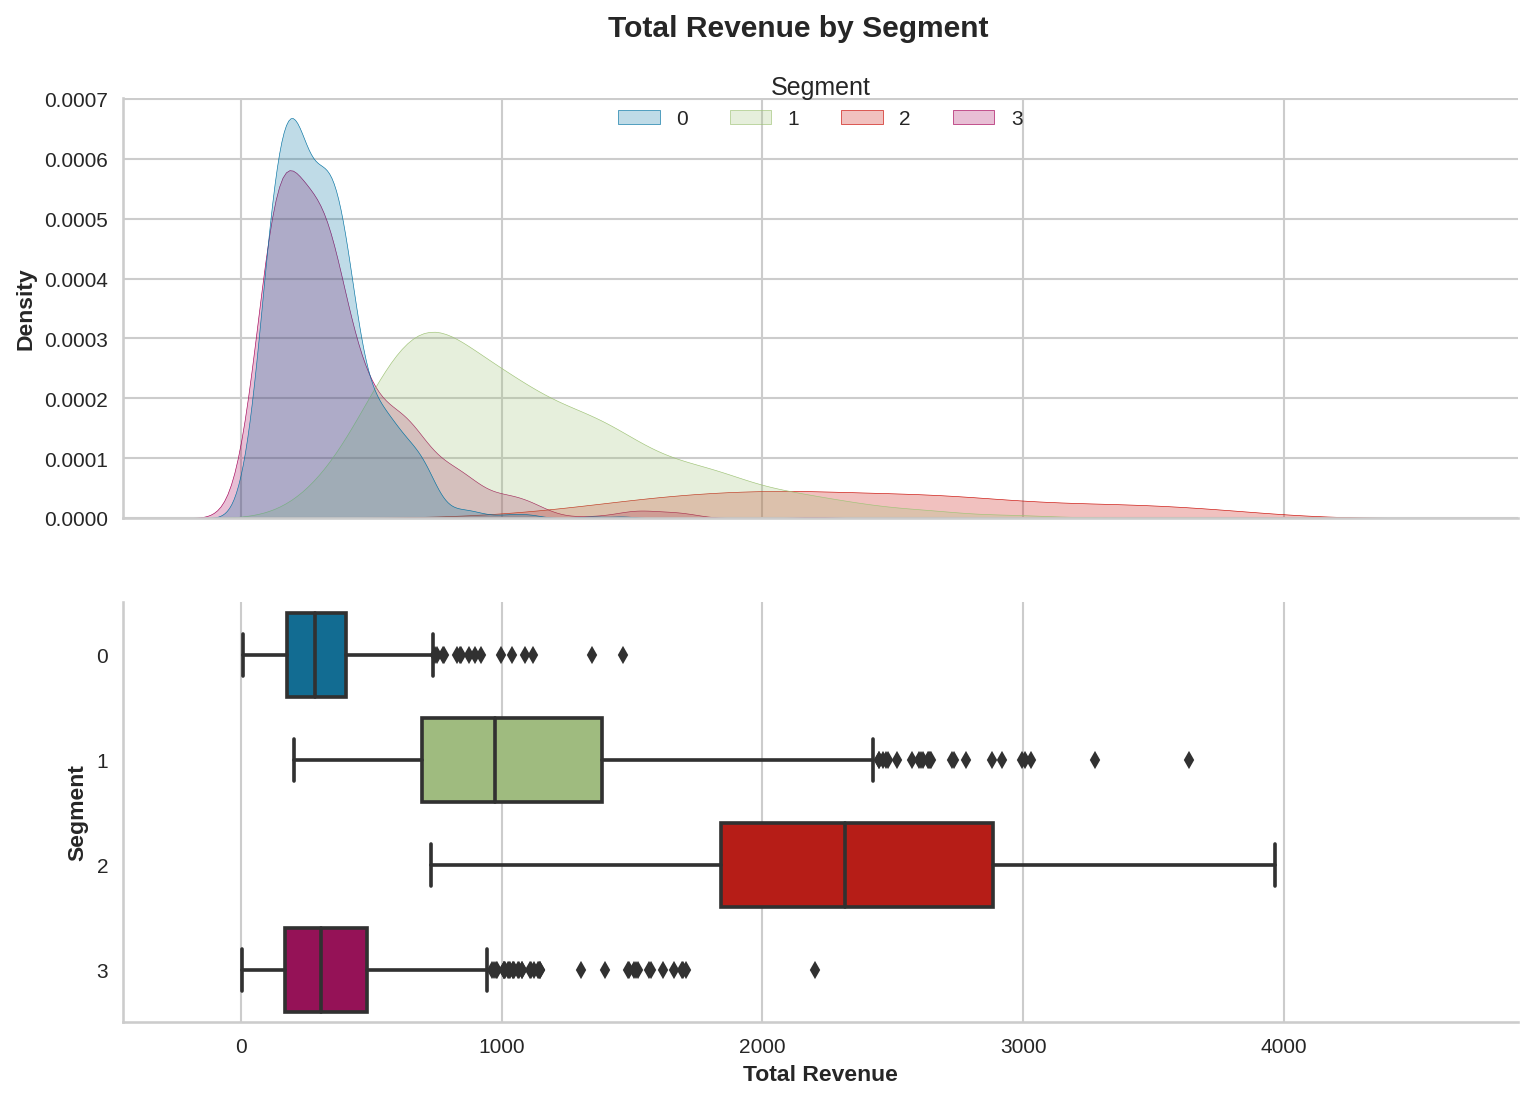

In [131]:
module.plot_kde_box(y= 'segment', x= 'total_revenue', df= df_clean)

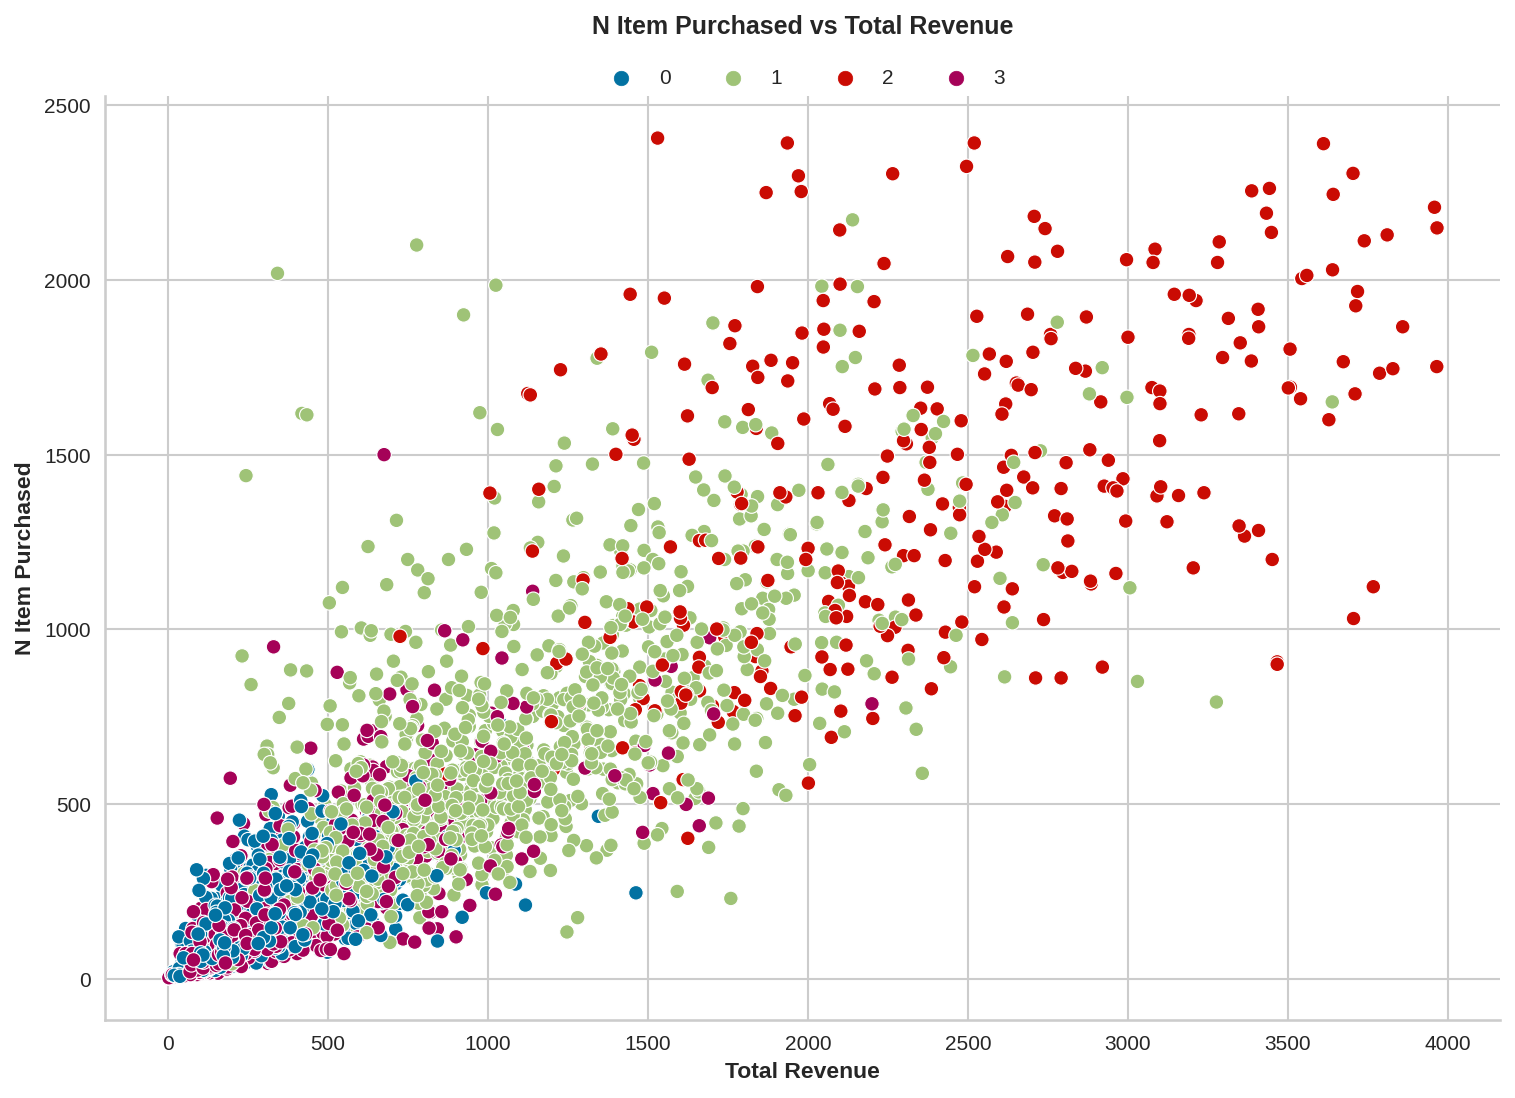

In [137]:
module.plot_scatter_with_centroids(
    x= 'total_revenue',
    y= 'n_item_purchased',
    scaler= scaler, 
    model= agglo, 
    df= df_clean
)

## Save DF

In [269]:
if not (path := Path("../output/segmentation_result.csv")).is_file():
    df_clean.to_csv(path, index=False)

# Sales Forecasting

## Feature Engineering

In [168]:
def prepare_for_forecasting(df):
    return (df
        .assign(ds=lambda df_: df_["invoice_date"].dt.date)
        .groupby("ds")
        .agg(y=("invoice_no", "nunique"))
        .reset_index()
        .sort_values("ds")
    )

df_forecast = prepare_for_forecasting(df)
df_forecast.head()

,ds,y
0,2010-12-01,136
1,2010-12-02,143
2,2010-12-03,73
3,2010-12-05,88
4,2010-12-06,108


## HP Tuning

In [201]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import optuna
from IPython.utils import io

In [214]:
def objective(trial):
    params = {
        "changepoint_prior_scale": trial.suggest_float("changepoint_prior_scale", 0.005, 5),
        "changepoint_range": trial.suggest_float("changepoint_range", 0.8, 0.9),
        "seasonality_prior_scale": trial.suggest_float("seasonality_prior_scale", 0.1, 10),
        "holidays_prior_scale": trial.suggest_float("holidays_prior_scale", 0.1, 10),
        "seasonality_mode": trial.suggest_categorical("seasonality_mode", ["multiplicative", "additive"]),
        "weekly_seasonality": trial.suggest_int("weekly_seasonality", 5, 10),
        "yearly_seasonality": trial.suggest_int("yearly_seasonality", 1, 20)
    }
    number_initial_days = df_forecast.shape[0]-28
    model = Prophet(**params)
    model.fit(df_forecast) 
    df_cv = cross_validation(model,
                            initial=f"{number_initial_days} days", 
                            period="7 days", 
                            horizon = "7 days",
                            parallel="processes"
                            )
    df_p = performance_metrics(df_cv)
    mape = df_p["mape"].mean()
    return mape

In [206]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

In [215]:
best_params = {
    'changepoint_prior_scale': 1.8840915504267643,
    'changepoint_range': 0.8355410945168996,
    'seasonality_prior_scale': 3.0649658167161427,
    'holidays_prior_scale': 4.85923239571044,
    'seasonality_mode': 'multiplicative',
    'weekly_seasonality': 9,
    'yearly_seasonality': 4
}

## Forecasting for the Last 2 Weeks

In [253]:
# create split
test_period = 14
train_set = df_forecast.iloc[:-test_period]
test_set = df_forecast.iloc[-test_period:]
assert ((len(test_set) + len(train_set)) == len(df_forecast))

# predict
m = Prophet(**best_params)
m.fit(train_set)
test_pred = m.predict(test_set)

# merge with test set
test_set = (test_set
    .assign(ds=lambda df_: pd.to_datetime(df_["ds"]))
    .merge(
        test_pred.loc[:, ["ds", "yhat", "yhat_lower", "yhat_upper"]], 
        on="ds", 
        how="left"
    )
)

# concat everything
df_forecast = pd.concat([train_set, test_set])

12:30:41 - cmdstanpy - INFO - Chain [1] start processing


12:30:41 - cmdstanpy - INFO - Chain [1] done processing


## Save DF

In [268]:
if not (path := Path("../output/forecast_result.csv")).is_file():
    df_forecast.fillna("NULL").to_csv(path, index=False)